# Import modules and define useful functions

In [49]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import json
import csv
import pandas as pd
import sklearn.feature_extraction.text as sk_text
import io
import requests
import numpy as np
import time
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from IPython.display import display
from matplotlib.pyplot import figure

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a confusion matrix.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a coefficient chart.
def report_coef(names,coef,intercept):
    #plt.figure(figsize=(18,270))
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    #r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    #plt.figure(figsize=(8,6))

#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
#We modified this to make it more powerful, full dataframe normalization
def encode_numeric_range(df, list, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    for i in range (0,len(list)):
        if data_low is None:
            data_low = min(df[list[i]])
            data_high = max(df[list[i]])
        df[list[i]] = ((df[list[i]] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
        data_low=None
        
#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
def chart_regression(pred,y,sort=True):
    plt.figure(figsize=(16,10))
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8,6))

#fix headers for census data
def fix_table(df,dropig=True):
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    df = df.astype({"Id2" : int})
    if dropig:
        df = df.drop(['Id','Geography'],axis=1)
    #drop DC and PR elections (they are for non-voting delagates) and cause lots of problems
    df.drop(df[df['Id2']%100==98].index, inplace=True)
    return df

# Code used to load the census data into a dataframe.
Used by both models, MAKE A COPY(don't overwrite df)

In [2]:
dp1  = pd.read_csv('census_data/DEC_00_110H_DP1_with_ann.csv', encoding="utf-8")
dp2  = pd.read_csv('census_data/DEC_00_110S_DP2_with_ann.csv', encoding="utf-8")
dp3  = pd.read_csv('census_data/DEC_00_110S_DP3_with_ann.csv', encoding="utf-8")
dp4  = pd.read_csv('census_data/DEC_00_110S_DP4_with_ann.csv', encoding="utf-8")
h002 = pd.read_csv('census_data/DEC_00_110H_H002_with_ann.csv', encoding="utf-8")

#fix headers
dp1  = fix_table(dp1, False)
dp2  = fix_table(dp2)
dp3  = fix_table(dp3)
dp4  = fix_table(dp4)
h002 = fix_table(h002)

df = dp1.copy()
df = df.merge(dp2,on="Id2")
df = df.merge(dp3,on="Id2")
df = df.merge(dp4,on="Id2")
df = df.merge(h002,on="Id2")

#fix typo in header
df.rename(columns={'Rural' : 'Rural:'},inplace=True)

#Cleaning useless columns
df.drop('Id', axis=1, inplace=True)
#df.drop('Id2', axis=1, inplace=True)
df.drop('Geography', axis=1, inplace=True)
df.drop('Not defined for this file', axis=1, inplace=True)
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.drop(list(df.filter(regex = 'Percent;')), axis = 1, inplace = True)

#fix types
df = df.astype(float)
df = df.astype({"Id2" : int})

#DONT OVERWRITE df IT NEEDS TO BE USED BY MULTIPLE MODELS AND EACH WILL WILL MAKE ITS OWN MODIFICATIONS TO DF
#get a copy using 'copy_of_df = df.copy()'
df

,Id2,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,101,635300.0,306620.0,328680.0,44487.0,47766.0,48163.0,47183.0,40743.0,82555.0,...,7284.0,6086.0,4146.0,18943.0,8395.0,281691.0,175729.0,133997.0,41732.0,105962.0
1,102,635300.0,308305.0,326995.0,42135.0,45367.0,46806.0,46145.0,43293.0,86835.0,...,7540.0,6036.0,4369.0,17616.0,10306.0,281290.0,136673.0,82178.0,54495.0,144617.0
2,103,635300.0,305852.0,329448.0,40841.0,44217.0,44661.0,50575.0,53426.0,84285.0,...,7114.0,5686.0,4166.0,22127.0,10631.0,286010.0,150521.0,113943.0,36578.0,135489.0
3,104,635300.0,310279.0,325021.0,40985.0,42916.0,43443.0,43253.0,37919.0,84993.0,...,5285.0,4803.0,2891.0,10959.0,10336.0,282766.0,76421.0,31756.0,44665.0,206345.0
4,105,635300.0,309694.0,325606.0,41451.0,44864.0,45366.0,44357.0,40175.0,87387.0,...,8144.0,6459.0,4549.0,17484.0,7688.0,278684.0,169089.0,147823.0,21266.0,109595.0
5,106,635300.0,310240.0,325060.0,41352.0,43273.0,44813.0,41260.0,38497.0,92508.0,...,6692.0,5131.0,3179.0,12319.0,6218.0,271212.0,169584.0,154689.0,14895.0,101628.0
6,107,635300.0,295514.0,339786.0,44741.0,46942.0,47000.0,51807.0,52812.0,84452.0,...,9297.0,7224.0,6176.0,28901.0,11932.0,282058.0,202666.0,186106.0,16560.0,79392.0
7,200,626932.0,324112.0,302820.0,47591.0,53771.0,56661.0,50094.0,39892.0,89473.0,...,10141.0,8082.0,6095.0,20903.0,11534.0,260978.0,157834.0,108417.0,49417.0,103144.0
8,401,641329.0,325515.0,315814.0,44745.0,50084.0,53966.0,51215.0,42419.0,75619.0,...,6721.0,5586.0,4143.0,17739.0,8408.0,293918.0,149292.0,51821.0,97471.0,144626.0
9,402,641329.0,313683.0,327646.0,40887.0,43918.0,43968.0,39237.0,31869.0,76244.0,...,6351.0,5552.0,3893.0,15875.0,4956.0,287665.0,253368.0,188931.0,64437.0,34297.0


In [3]:
#Check dataframe for NAN values
df.isnull().sum().sum()

0

# Print all the column names that are in the input table

In [4]:
columnnames = list(df.columns)
print('\n'.join(map(str, columnnames)))

Id2
Number; Total population
Number; Total population - SEX AND AGE - Male
Number; Total population - SEX AND AGE - Female
Number; Total population - SEX AND AGE - Under 5 years
Number; Total population - SEX AND AGE - 5 to 9 years
Number; Total population - SEX AND AGE - 10 to 14 years
Number; Total population - SEX AND AGE - 15 to 19 years
Number; Total population - SEX AND AGE - 20 to 24 years
Number; Total population - SEX AND AGE - 25 to 34 years
Number; Total population - SEX AND AGE - 35 to 44 years
Number; Total population - SEX AND AGE - 45 to 54 years
Number; Total population - SEX AND AGE - 55 to 59 years
Number; Total population - SEX AND AGE - 60 to 64 years
Number; Total population - SEX AND AGE - 65 to 74 years
Number; Total population - SEX AND AGE - 75 to 84 years
Number; Total population - SEX AND AGE - 85 years and over
Number; Total population - SEX AND AGE - Median age (years)
Number; Total population - SEX AND AGE - 18 years and over
Number; Total population - SEX

# Load the simple results table
Loads the data in election_results.csv. Only stores which party won, not by how much.
Used by the binary classifier

In [5]:
res  = pd.read_csv('census_data/election_results.csv', encoding="utf-8")
res  = fix_table(res)
res = res.reset_index()
res.drop('index', axis=1, inplace=True)
res

,Id2,winner
0,101,R
1,102,R
2,103,R
3,104,R
4,105,D
5,106,R
6,107,D
7,200,R
8,401,R
9,402,R


# Clean up broken utf-8 characters in the house election results table
The broken encoding causes pandas to fail to load the characters
The utf-8 encoding of the election results file which has the percent values for wins is screwed up.  This code fixes it.

In [6]:
#--------------------ONLY NEED TO DO THIS ONCE--------------------
#code to remove screwed up invalid utf-8 chars
with open('census_data/house_results.csv', 'rb') as f:
    ftxt = f.read().decode('utf-8', 'ignore')
with open('census_data/house_results_clean.csv', 'w') as f:
    f.write(ftxt)

# Load the win percentages

This code loads the percent by which each election was won

In [7]:
#get precent votes for `06 election
hres = pd.read_csv('census_data/house_results_clean.csv', encoding="utf-8")
#remove non `06 results
hres = hres.loc[hres['year'] == 2006]
hres = hres.loc[hres['stage'] == 'gen']
hres = hres.sort_values(by=['state', 'district'])
hres = hres.astype({'candidatevotes' : float, 'totalvotes' : float})
hres = hres.loc[:,hres.columns.isin(['state','district', 'party', 'candidatevotes', 'totalvotes'])]

#get the total votes
hres['party'] = hres['party'].apply(lambda x: 'democrat' if x=='democratic-farmer-labor' else x)
dVotes = hres.loc[hres['party']=='democrat']
rVotes = hres.loc[hres['party']=='republican']
dVotes = dVotes.assign(dVotePct= dVotes['candidatevotes'] / dVotes['totalvotes'])
rVotes = rVotes.assign(rVotePct= rVotes['candidatevotes'] / rVotes['totalvotes'])

hres = dVotes.copy()
hres = hres.merge(rVotes, on=['state', 'district'], how='outer')
hres=hres.rename(columns={'candidatevotes_x':'dVoteCnt','candidatevotes_y':'rVoteCnt','totalvotes_x':'tvotes'})

#fill nan's from uncontested elections
hres = hres.fillna(0)

#at this point we have the votes in a table, now to merge it into the big table above
#I decided that the best way to do this is by calculating each states census id and then joining the tables
stateSeq = hres.groupby(by="state").first()
stateSeq = stateSeq.reset_index()
stateSeq = stateSeq.assign(indx=stateSeq['state'].index+1)

#there are some gaps (caused by territories) that causes the house results to be unalligned w/ the census
for i in (3,7,11,14,43,52):
    stateSeq['indx'] = stateSeq['indx'].apply(lambda x: x+1 if x>=i else x)

#cleanup the house results table & remove no longer needed columns
stateSeq = stateSeq.loc[:,stateSeq.columns.isin(['state','indx'])]
hres = hres.merge(stateSeq,on='state')
hres = hres.assign(Id2=hres['indx']*100+hres['district'])
hres = hres.loc[:,hres.columns.isin(['dVotePct','rVotePct','Id2'])]
hres = hres.reset_index()
hres.drop('index', axis=1, inplace=True)
hres

,dVotePct,rVotePct,Id2
0,0.318196,0.681038,101
1,0.304328,0.694739,102
2,0.384505,0.594413,103
3,0.297053,0.701822,104
4,0.982550,0.000000,105
5,0.990426,0.000000,107
6,0.000000,0.983247,106
7,0.400089,0.565718,200
8,0.434464,0.517520,401
9,0.388927,0.586181,402


# Binary Classifier
It perdicts which party will win based off of the census data for the district, and does not attempt to determine which portion of the votes each party will win

In [8]:
#First we make a copy of the input dataframe
#and join the results table(and then get rid of the Id2 column, b/c it will not be needed)
ddf = df.copy()
ddf = ddf.merge(res, on="Id2")
ddf.drop("Id2", axis=1, inplace=True)

#Encodes Democrat and Republican winners in a 2d array in 'outputs' this will go to our classification model
#Encodes Democrat Winners as 1 and Republican winners as 0 in a 1d array in 'winners' this will go to the logistic regression model for feature importance
winners = ddf.filter(['winner'])
encoder = preprocessing.LabelBinarizer()
encoder.fit(['D','R'])
winners['result'] = encoder.transform(winners['winner'])
winners['result'] = np.logical_xor(winners['result'],1).astype(int)
winners.drop('winner', axis=1, inplace=True)
outputs = winners.copy()
outputs.columns = ['Democrat']
outputs['Republican'] = np.logical_xor(outputs['Democrat'],1).astype(int)
ddf.drop('winner', axis=1, inplace=True)
outputs

,Democrat,Republican
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


In [9]:
#normalize dataframe
encode_numeric_range(ddf, list(ddf.columns), 0, 1)
ddf

,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,Number; Total population - SEX AND AGE - 35 to 44 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,0.346507,0.289628,0.401684,0.361375,0.500343,0.559825,0.429037,0.271253,0.230556,0.296505,...,0.120014,0.116077,0.103110,0.145708,0.513885,0.494311,0.367890,0.365028,0.282223,0.367448
1,0.346507,0.298007,0.393556,0.315595,0.450421,0.531563,0.410553,0.310724,0.274024,0.294669,...,0.130174,0.113715,0.117802,0.126617,0.652806,0.492763,0.238877,0.223865,0.368536,0.501493
2,0.346507,0.285809,0.405389,0.290408,0.426490,0.486890,0.489440,0.467572,0.248126,0.222964,...,0.113267,0.097180,0.104427,0.191515,0.676432,0.510991,0.284621,0.310398,0.247368,0.469839
3,0.346507,0.307823,0.384034,0.293211,0.399417,0.461522,0.359053,0.227540,0.255317,0.261872,...,0.040679,0.055464,0.020424,0.030845,0.654987,0.498463,0.039848,0.086508,0.302058,0.715549
4,0.346507,0.304914,0.386856,0.302281,0.439954,0.501572,0.378713,0.262461,0.279631,0.419574,...,0.154145,0.133699,0.129661,0.124718,0.462489,0.482699,0.345956,0.402692,0.143816,0.380046
5,0.346507,0.307629,0.384222,0.300354,0.406846,0.490055,0.323563,0.236487,0.331641,0.418070,...,0.096519,0.070960,0.039399,0.050411,0.355627,0.453842,0.347591,0.421396,0.100731,0.352419
6,0.346507,0.234404,0.455257,0.366319,0.483196,0.535603,0.511379,0.458068,0.249822,0.209890,...,0.199905,0.169840,0.236856,0.288970,0.771009,0.495729,0.456871,0.506981,0.111991,0.275310
7,0.326018,0.376607,0.276942,0.421792,0.625304,0.736811,0.480875,0.258080,0.300817,0.558503,...,0.233401,0.210375,0.231519,0.173906,0.742076,0.414319,0.308778,0.295344,0.334194,0.357676
8,0.361269,0.383584,0.339622,0.366397,0.548580,0.680683,0.500837,0.297195,0.160113,0.187350,...,0.097670,0.092455,0.102912,0.128386,0.514830,0.541531,0.280561,0.141168,0.659171,0.501524
9,0.361269,0.324749,0.396697,0.291303,0.420268,0.472457,0.287538,0.133893,0.166460,0.177726,...,0.082986,0.090849,0.086441,0.101570,0.263885,0.517383,0.624354,0.514676,0.435771,0.118933


In [10]:
parties = list(outputs)
names = list(ddf)

In [11]:
x = ddf.to_numpy('float32')
y = outputs.to_numpy('float32')
print(x.shape)
print(y.shape)

(435, 398)
(435, 2)


In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=(int(time.time()) % 1000))

In [13]:
checkpoint = ModelCheckpoint(filepath="best_weights_binary.hdf5", verbose=1, save_best_only=True)

In [14]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

W1124 02:49:07.142802 15824 deprecation.py:506] From C:\Users\Randall\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.55404, saving model to best_weights_binary.hdf5
326/326 - 1s - loss: 0.5792 - val_loss: 0.5540
Epoch 2/100

Epoch 00002: val_loss improved from 0.55404 to 0.53406, saving model to best_weights_binary.hdf5
326/326 - 0s - loss: 0.4822 - val_loss: 0.5341
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4295 - val_loss: 0.5406
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4073 - val_loss: 0.6404
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4032 - val_loss: 0.5427
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.3973 - val_loss: 0.7369
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5161 - val_loss: 0.5399
Epoch 00007: early stopping


In [15]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='sigmoid'))
model.add(Dense(132, activation='sigmoid'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6848 - val_loss: 0.7024
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6309 - val_loss: 0.6400
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5814 - val_loss: 0.6182
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5660 - val_loss: 0.7468
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5597 - val_loss: 0.6585
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5465 - val_loss: 0.5522
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4839 - val_loss: 0.5552
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5050 - val_loss: 0.5440
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.53406
32

In [16]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='tanh'))
model.add(Dense(132, activation='tanh'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.8107 - val_loss: 0.5761
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5429 - val_loss: 0.5592
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4773 - val_loss: 0.5589
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4492 - val_loss: 0.5370
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4568 - val_loss: 0.5934
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4649 - val_loss: 0.5342
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.4037 - val_loss: 0.5488
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.3924 - val_loss: 0.5704
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.53406
32

In [17]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.7035 - val_loss: 0.6732
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6585 - val_loss: 0.6496
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6295 - val_loss: 0.6408
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6101 - val_loss: 0.6223
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5923 - val_loss: 0.6121
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5766 - val_loss: 0.6043
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5635 - val_loss: 0.6160
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5503 - val_loss: 0.5895
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.53406
32

In [18]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='sigmoid'))
model.add(Dense(132, activation='sigmoid'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.7067 - val_loss: 0.6847
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6971 - val_loss: 0.6855
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6971 - val_loss: 0.6851
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6953 - val_loss: 0.6872
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6933 - val_loss: 0.6871
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6955 - val_loss: 0.6854
Epoch 00006: early stopping


In [19]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='tanh'))
model.add(Dense(132, activation='tanh'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.7275 - val_loss: 0.7206
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.6217 - val_loss: 0.6921
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5845 - val_loss: 0.6026
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5535 - val_loss: 0.5915
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5258 - val_loss: 0.7172
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5297 - val_loss: 0.5968
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5154 - val_loss: 0.5986
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.53406
326/326 - 0s - loss: 0.5112 - val_loss: 0.5857
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.53406
32

In [20]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.load_weights('best_weights_binary.hdf5')

In [21]:
pred = model.predict(xtest)
for i in range(10):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,parties[np.argmax(ytest[i])],parties[np.argmax(pred[i])]))

1. Actual Party: Republican		Predicted Party: Republican
2. Actual Party: Republican		Predicted Party: Republican
3. Actual Party: Democrat		Predicted Party: Democrat
4. Actual Party: Republican		Predicted Party: Republican
5. Actual Party: Democrat		Predicted Party: Republican
6. Actual Party: Democrat		Predicted Party: Democrat
7. Actual Party: Democrat		Predicted Party: Republican
8. Actual Party: Democrat		Predicted Party: Democrat
9. Actual Party: Democrat		Predicted Party: Democrat
10. Actual Party: Republican		Predicted Party: Republican


In [22]:
ytrue = np.argmax(ytest, axis=1)
p = np.argmax(pred, axis=1)

In [23]:
accuracy = metrics.accuracy_score(ytrue,p)
print("Accuracy score: {}".format(accuracy))
prec = metrics.precision_score(ytrue, p, average="weighted")
print("Precision score: {}".format(prec))
recall = metrics.recall_score(ytrue, p, average="weighted")
print("Recall score: {}".format(recall))
f1 = metrics.f1_score(ytrue, p, average="weighted")
print("F1 score: {}".format(f1))
print("\n\t\t\tCLASSIFICATION REPORT\n")
print(metrics.classification_report(ytrue, p))

Accuracy score: 0.7339449541284404
Precision score: 0.747178204058938
Recall score: 0.7339449541284404
F1 score: 0.7355660054361117

			CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        63
           1       0.65      0.78      0.71        46

    accuracy                           0.73       109
   macro avg       0.73      0.74      0.73       109
weighted avg       0.75      0.73      0.74       109



[[44 19]
 [10 36]]


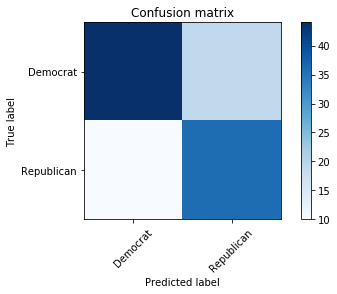

In [24]:
cm = confusion_matrix(ytrue, p)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['Democrat','Republican'])
plt.show()

In [25]:
ymod = winners.to_numpy('float32')
regressor = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(x,np.ravel(ymod))

In [26]:
report_coef(
  names,
  np.ravel(regressor.coef_),
  regressor.intercept_)

,coef,positive
"Number; Employed civilian population 16 years and over - INDUSTRY - Finance, insurance, real estate, and rental and leasing",-0.733387,False
Number; Total housing units - UNITS IN STRUCTURE - Mobile home,-0.646445,False
"Number; EDUCATIONAL ATTAINMENT - Population 25 years and over - 9th to 12th grade, no diploma",-0.561603,False
Number; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Cuban,-0.550335,False
Number; RESIDENCE IN 1995 - Population 5 years and over - Different house in the U.S. in 1995 - Same county,-0.509883,False
Number; HOUSING OCCUPANCY - Total housing units - Rental vacancy rate (percent),-0.506553,False
Number; Specified owner-occupied units - MORTGAGE STATUS AND SELECTED MONTHLY OWNER COSTS - With a mortgage - $700 to $999,-0.470395,False
Number; Total housing units - YEAR STRUCTURE BUILT - 1980 to 1989,-0.454941,False
Number; Occupied Housing Units - SELECTED CHARACTERISTICS - Lacking complete kitchen facilities,-0.446731,False
"Number; EDUCATIONAL ATTAINMENT - Population 25 years and over - Some college, no degree",-0.427954,False


Intercept: [0.67510579]


# Regression model
The regression model assumes that the all votes go to either democrats or republicans
However, because of third parties dVotePct+rVotePct sometimes don't add up to 100%.
This model will perdict the % of voters who vote Democrat in a district,
and assume that all other vote Republican.
we assume that if there were no 3rd parties half of the 3rd party votes would go republican
and half would go democratic
the vote percentages (with such assumption) are defined to be the adjusted democratic votes
and adjusted republican votes respectively
adjDVote+adjRVote always equals 100, and the code predicts adjDVote

In [27]:
#copy the input dataframe, merge the results df, and drop Id2
rdf = df.copy()
rdf = rdf.merge(hres, on="Id2")
rdf.drop("Id2", axis=1, inplace=True)

#calculate the adjusted democratic vote
advTab = rdf.filter(['dVotePct', 'rVotePct'])
rdf.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)
advTab['adjDVote'] = advTab['dVotePct'] + (1-(advTab['dVotePct']+advTab['rVotePct']))/2
advTab.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)

advTab

,adjDVote
0,0.318579
1,0.304794
2,0.395046
3,0.297615
4,0.991275
5,0.008376
6,0.995213
7,0.417186
8,0.458472
9,0.401373


In [28]:
#normalize dataframe
encode_numeric_range(rdf, list(rdf.columns), 0, 1)
rdf

In [47]:
cnames = list(rdf)

In [29]:
cx = rdf.to_numpy('float32')
cy = advTab.to_numpy('float32')
print(cx.shape)
print(cy.shape)

(436, 398)
(436, 1)


In [30]:
cxtrain,cxtest,cytrain,cytest=train_test_split(cx, cy, test_size=0.25, random_state=(int(time.time()) % 1000))

In [31]:
ccheckpoint = ModelCheckpoint(filepath="best_weights_regression.hdf5", verbose=1, save_best_only=True)

In [32]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.04582, saving model to best_weights_regression.hdf5
327/327 - 0s - loss: 0.1372 - val_loss: 0.0458
Epoch 2/100

Epoch 00002: val_loss improved from 0.04582 to 0.03752, saving model to best_weights_regression.hdf5
327/327 - 0s - loss: 0.0382 - val_loss: 0.0375
Epoch 3/100

Epoch 00003: val_loss improved from 0.03752 to 0.02719, saving model to best_weights_regression.hdf5
327/327 - 0s - loss: 0.0327 - val_loss: 0.0272
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02719
327/327 - 0s - loss: 0.0282 - val_loss: 0.0300
Epoch 5/100

Epoch 00005: val_loss improved from 0.02719 to 0.02658, saving model to best_weights_regression.hdf5
327/327 - 0s - loss: 0.0247 - val_loss: 0.0266
Epoch 6/100

Epoch 00006: val_loss improved from 0.02658 to 0.02316, saving model to best_weights_regression.hdf5
327/327 - 0s - loss: 0.0219 - val_loss: 0.0232
Epoch 7/100

Epoch 00007: val_loss did not

In [33]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='sigmoid'))
cmodel.add(Dense(132, activation='sigmoid'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.3742 - val_loss: 0.1256
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0945 - val_loss: 0.0673
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0457 - val_loss: 0.0416
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0376 - val_loss: 0.0335
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0313 - val_loss: 0.0326
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0295 - val_loss: 0.0324
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0286 - val_loss: 0.0295
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0282 - val_loss: 0.0295
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02213
32

In [34]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='tanh'))
cmodel.add(Dense(132, activation='tanh'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.6696 - val_loss: 0.1707
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.1263 - val_loss: 0.0931
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0568 - val_loss: 0.0333
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0298 - val_loss: 0.0275
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0246 - val_loss: 0.0257
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0252 - val_loss: 0.0250
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0227 - val_loss: 0.0244
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0276 - val_loss: 0.0267
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02213
32

In [35]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0786 - val_loss: 0.0449
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0437 - val_loss: 0.0394
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0355 - val_loss: 0.0354
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0346 - val_loss: 0.0318
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0323 - val_loss: 0.0304
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0302 - val_loss: 0.0322
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0301 - val_loss: 0.0342
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0285 - val_loss: 0.0295
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02213
32

In [36]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='sigmoid'))
cmodel.add(Dense(132, activation='sigmoid'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0476 - val_loss: 0.0445
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0470 - val_loss: 0.0439
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0468 - val_loss: 0.0450
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0451 - val_loss: 0.0439
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0457 - val_loss: 0.0519
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0459 - val_loss: 0.0444
Epoch 00006: early stopping


In [37]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='tanh'))
cmodel.add(Dense(132, activation='tanh'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.7290 - val_loss: 0.0707
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0425 - val_loss: 0.0439
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0357 - val_loss: 0.0345
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0367 - val_loss: 0.0321
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0337 - val_loss: 0.0515
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0339 - val_loss: 0.0343
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0310 - val_loss: 0.0336
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02213
327/327 - 0s - loss: 0.0307 - val_loss: 0.0288
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02213
32

In [38]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmodel.load_weights('best_weights_regression.hdf5')

In [39]:
cpred = cmodel.predict(cxtest)

for i in range(10):
    print("{}. Actual Dem % of vote: {}\t\tPredicted Dem % of vote: {}".format(i+1,cytest[i][0],cpred[i][0]))

1. Actual Dem % of vote: 0.5187847018241882		Predicted Dem % of vote: 0.4824811518192291
2. Actual Dem % of vote: 0.4006968140602112		Predicted Dem % of vote: 0.39261355996131897
3. Actual Dem % of vote: 0.6652509570121765		Predicted Dem % of vote: 0.43705061078071594
4. Actual Dem % of vote: 1.0		Predicted Dem % of vote: 0.901818573474884
5. Actual Dem % of vote: 0.09633222967386246		Predicted Dem % of vote: 0.3755490183830261
6. Actual Dem % of vote: 0.5054898262023926		Predicted Dem % of vote: 0.4142887592315674
7. Actual Dem % of vote: 0.6569796204566956		Predicted Dem % of vote: 0.5607807040214539
8. Actual Dem % of vote: 0.7222430109977722		Predicted Dem % of vote: 0.6043625473976135
9. Actual Dem % of vote: 0.37768012285232544		Predicted Dem % of vote: 0.37227314710617065
10. Actual Dem % of vote: 0.5561079978942871		Predicted Dem % of vote: 0.4101668894290924


In [40]:
pctToParty = ['Republican', 'Democrat']
for i in range(11,20):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,pctToParty[int(np.round(cytest[i][0]))],pctToParty[int(np.round(cpred[i][0]))]))

12. Actual Party: Republican		Predicted Party: Republican
13. Actual Party: Democrat		Predicted Party: Democrat
14. Actual Party: Republican		Predicted Party: Republican
15. Actual Party: Democrat		Predicted Party: Democrat
16. Actual Party: Democrat		Predicted Party: Democrat
17. Actual Party: Democrat		Predicted Party: Democrat
18. Actual Party: Republican		Predicted Party: Republican
19. Actual Party: Democrat		Predicted Party: Republican
20. Actual Party: Republican		Predicted Party: Democrat


In [41]:
score = np.sqrt(metrics.mean_squared_error(cmodel.predict(cxtest),cytest))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.14876876771450043


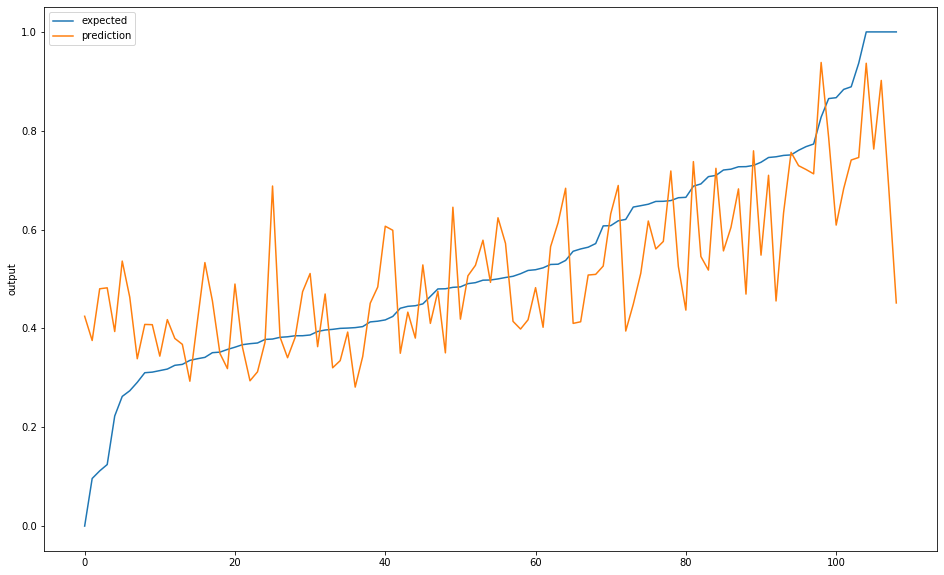

<Figure size 576x432 with 0 Axes>

In [56]:
crxtest=cxtest[0:109]
crytest=cytest[0:109]
chart_regression(cmodel.predict(cxtest).flatten(),cytest, sort=True)

In [55]:
cregressor = LinearRegression().fit(cx,np.ravel(cy))
report_coef(
  cnames,
  np.ravel(cregressor.coef_),
  cregressor.intercept_)

,coef,positive
Number; REGION OF BIRTH OF FOREIGN BORN - Total (excluding born at sea),-16846.082031,False
Number; REGION OF BIRTH OF FOREIGN BORN - Total (excluding born at sea) - Latin America,-12806.508789,False
Number; REGION OF BIRTH OF FOREIGN BORN - Total (excluding born at sea) - Asia,-6753.647461,False
Number; REGION OF BIRTH OF FOREIGN BORN - Total (excluding born at sea) - Europe,-3951.816650,False
Number; NATIVITY AND PLACE OF BIRTH - Total population - Native,-3721.497314,False
Number; NATIVITY AND PLACE OF BIRTH - Total population - Native - Born in United States,-3519.648193,False
Number; NATIVITY AND PLACE OF BIRTH - Total population - Native - Born in United States - State of residence,-2621.885498,False
Number; NATIVITY AND PLACE OF BIRTH - Total population - Native - Born in United States - Different state,-2198.598389,False
Number; NATIVITY AND PLACE OF BIRTH - Total population - Native - Born outside United States,-943.377991,False
Number; REGION OF BIRTH OF FOREIGN BORN - Total (excluding born at sea) - Africa,-840.382935,False


Intercept: 4838.46142578125
